# Anomaly Detection Notebook

This notebook documents the end-to-end workflow for video anomaly detection on the UCSD Ped dataset: loading raw clips, exploratory data analysis (EDA) of frames and motion, preprocessing/sequence construction, model training with a recurrent U‑Net (ConvLSTM), evaluation, and exporting the final model to ONNX for deployment.

Outline:

- Configuration and data loading (UCSD Ped1/Ped2)
- EDA: frame stats, motion masks, anomaly examples
- Preprocessing and sequence creation
- Train/validation split and dataloaders
- Model training and hyperparameter sweep
- Evaluation and visualization
- Export to ONNX and inference checks

## EDA

clips: 46
frames per clip (sample): [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
resolutions (sample): [(158, 238), (158, 238), (158, 238), (158, 238), (158, 238), (158, 238), (158, 238), (158, 238), (158, 238), (158, 238)]


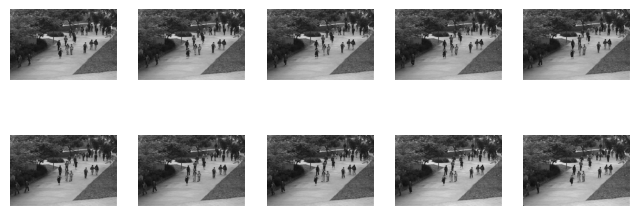

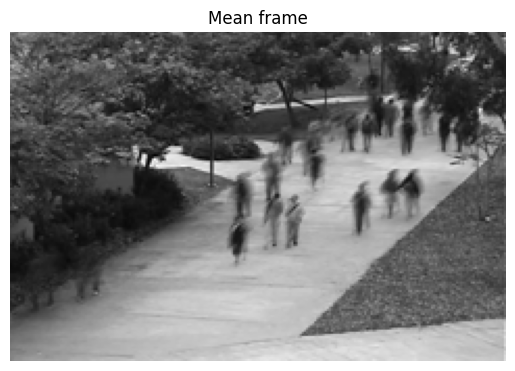

min/max: 0 252
mean/std: 99.62326880119136 53.05420542141345


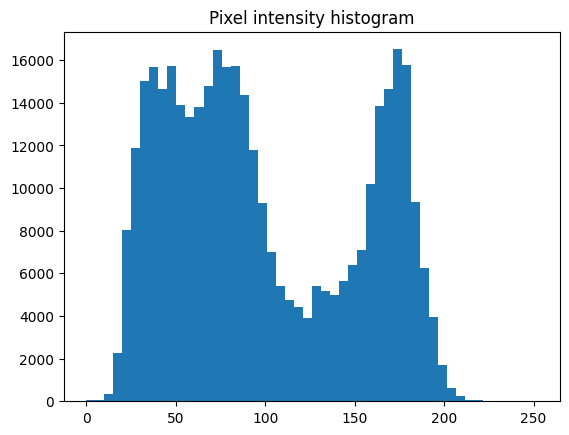

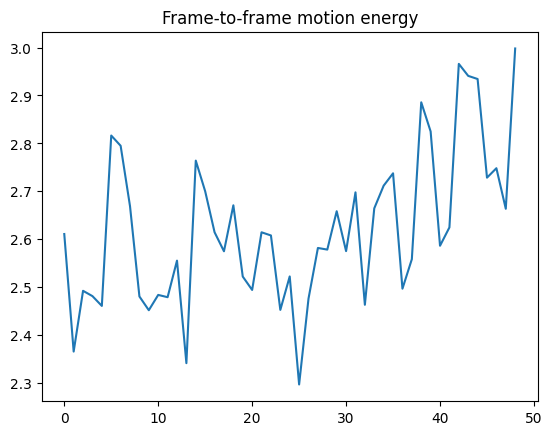

In [23]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_root = project_root / "data"
ucsd_root = next(data_root.glob("UCSD*"), None)
if ucsd_root is None:
    raise FileNotFoundError(f"No UCSD dataset found under {data_root}")

root = ucsd_root / "UCSDped1" / "Test"  # change if needed
if not root.exists():
    raise FileNotFoundError(f"Path not found: {root}")

clips = sorted([p for p in root.iterdir() if p.is_dir()])
print("clips:", len(clips))

# find a clip with actual frames
frame_exts = ("*.tif", "*.tiff", "*.jpg", "*.jpeg", "*.png", "*.bmp")

def get_frames(clip):
    for ext in frame_exts:
        frames = sorted(clip.glob(ext))
        if frames:
            return frames
    return []

first_clip = None
first_frames = None
for clip in clips:
    frames = get_frames(clip)
    if frames:
        first_clip = clip
        first_frames = frames
        break

if first_clip is None:
    raise RuntimeError("No frames found. Check dataset structure/extension.")

# visualize a clip
frames = first_frames[:10]
imgs = [cv2.imread(str(f), cv2.IMREAD_GRAYSCALE) for f in frames]

fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for ax, img in zip(axes.flat, imgs):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.show()

# mean frame
mean_frame = np.mean(np.stack(imgs), axis=0)
plt.imshow(mean_frame, cmap="gray")
plt.title("Mean frame")
plt.axis("off")
plt.show()

# prepare full frame stack for later motion analysis
frames_full = [cv2.imread(str(f), cv2.IMREAD_GRAYSCALE) for f in first_frames[:50]]
frames_full = np.stack(frames_full).astype(np.float32)


Sample frames and mean frame

What was done: Displayed a grid of sample frames from a test clip and computed the mean frame.
Finding: The scene is largely static, and the mean frame highlights the stable background.
Why it matters: Provides visual context and supports learning predictable background dynamics.


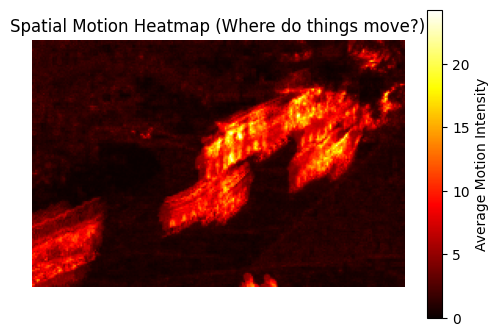

In [ ]:
# Calculate the mean absolute difference across ALL frames in the clip

# Calculate difference between consecutive frames
diffs = np.abs(np.diff(frames_full, axis=0))

# Take the mean across the time axis (axis 0)
motion_heatmap = np.mean(diffs, axis=0)

plt.figure(figsize=(6, 4))
plt.imshow(motion_heatmap, cmap="hot")
plt.colorbar(label="Average Motion Intensity")
plt.title("Spatial Motion Heatmap (Where do things move?)")
plt.axis("off")
plt.show()

Spatial motion heatmap

What was done: Computed the mean absolute difference between consecutive frames and averaged it over time to visualize where temporal changes occur.

Finding: Most motion is concentrated along the walkway; large regions remain static across time.

Why it matters: This supports the sequence‑prediction training objective (next‑frame prediction with ConvLSTM). The model can learn typical temporal dynamics in the active region while treating static background as predictable context, which matches how the training data is structured.


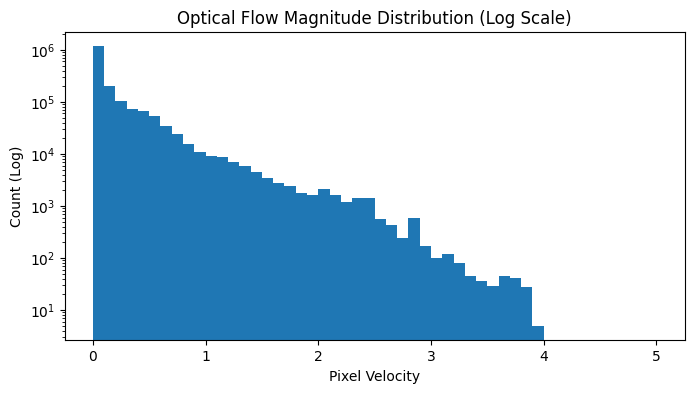

In [ ]:
prev_gray = cv2.imread(str(first_frames[0]), cv2.IMREAD_GRAYSCALE)
magnitudes = []

# Analyze first 50 frames
for f_path in first_frames[1:50]:
    next_gray = cv2.imread(str(f_path), cv2.IMREAD_GRAYSCALE)
    
    # Calculate Dense Optical Flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Compute Magnitude and Angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    magnitudes.append(mag.flatten())
    
    prev_gray = next_gray

# Flatten all magnitudes
all_mags = np.concatenate(magnitudes)

# Plot Histogram of velocities
plt.figure(figsize=(8, 4))
plt.hist(all_mags, bins=50, range=(0, 5), log=True)
plt.title("Optical Flow Magnitude Distribution (Log Scale)")
plt.xlabel("Pixel Velocity")
plt.ylabel("Count (Log)")
plt.show()




Optical flow magnitude distribution

What was done: Farneback optical flow was used to compute per‑pixel motion magnitude and a histogram of speeds.

Finding: Most pixels have near‑zero velocity (static background), with a small tail representing pedestrian motion.

Why it matters: This supports framing anomaly detection as identifying rare foreground motion patterns against a largely static scene.


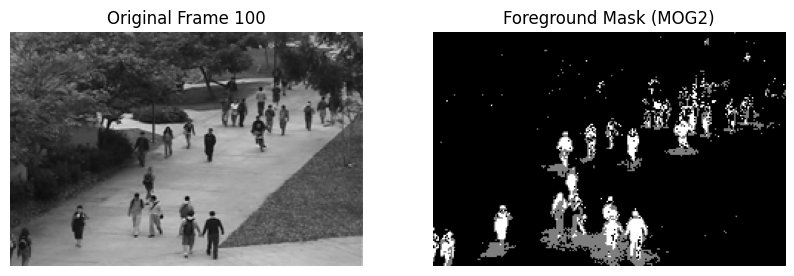

In [18]:
backSub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)

# Process a chunk of frames
fg_masks = []
for f_path in first_frames[:100]:
    frame = cv2.imread(str(f_path))
    fgMask = backSub.apply(frame)
    fg_masks.append(fgMask)

# Visualize the last mask
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(str(first_frames[99])), cv2.COLOR_BGR2RGB))
plt.title("Original Frame 100")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(fg_masks[-1], cmap="gray")
plt.title("Foreground Mask (MOG2)")
plt.axis("off")
plt.show()

Foreground mask (MOG2)

What was done: Applied MOG2 background subtraction over the first 100 frames and visualized the resulting foreground mask.

Finding: Moving pedestrians are highlighted in the mask, while static pavement/background is largely suppressed.

Why it matters: This shows that motion segmentation can isolate the dynamic regions the model needs to predict, and motivates focusing anomaly scoring on motion rather than static context.


clips: 16
Total Clips found: 16
Total Frames found: 2550
Min frames in a clip: 120
Max frames in a clip: 180


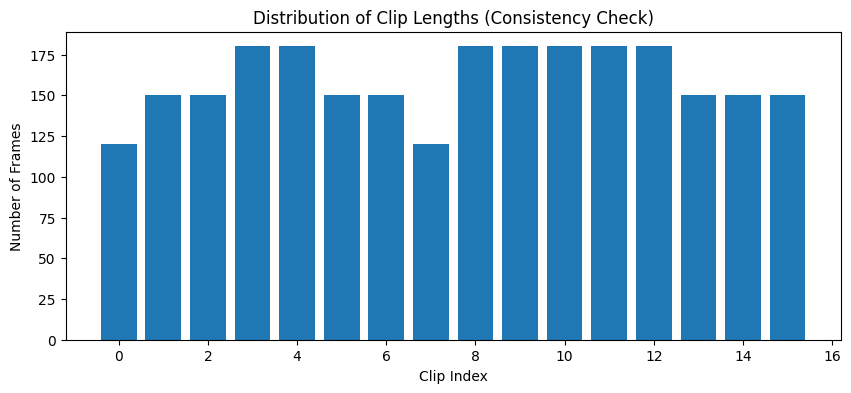

In [ ]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# --- Configuration ---
# Update this path to point to your actual data location
#DATA_PATH = Path("data/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train")

# 1. Data Integrity & Structure
#print("## 1. Data Integrity Check")
#clips = sorted([d for d in DATA_PATH.iterdir() if d.is_dir()])


project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_root = project_root / "data"
ucsd_root = next(data_root.glob("UCSD*"), None)
if ucsd_root is None:
    raise FileNotFoundError(f"No UCSD dataset found under {data_root}")

root = ucsd_root / "UCSDped2" / "Train"  # change if needed
if not root.exists():
    raise FileNotFoundError(f"Path not found: {root}")

clips = sorted([p for p in root.iterdir() if p.is_dir()])
print("clips:", len(clips))


frame_counts = []

for clip in clips:
    frames = sorted(glob.glob(os.path.join(clip, "*.tif")))
    frame_counts.append(len(frames))

print(f"Total Clips found: {len(clips)}")
print(f"Total Frames found: {sum(frame_counts)}")
print(f"Min frames in a clip: {min(frame_counts)}")
print(f"Max frames in a clip: {max(frame_counts)}")

plt.figure(figsize=(10, 4))
plt.bar(range(len(clips)), frame_counts)
plt.xlabel("Clip Index")
plt.ylabel("Number of Frames")
plt.title("Distribution of Clip Lengths (Consistency Check)")
plt.show()





Clip length distribution

What was done: Counted frames per training clip and plotted the distribution.
Finding: Clip lengths are consistent and exceed the chosen sequence length.
Why it matters: Confirms sequences can be sampled safely without short‑clip failures.



## 2. Spatial Analysis
Original Resolution: 360x240
Channels: 3
✅ R, G, and B channels are identical. Using Grayscale is lossless.


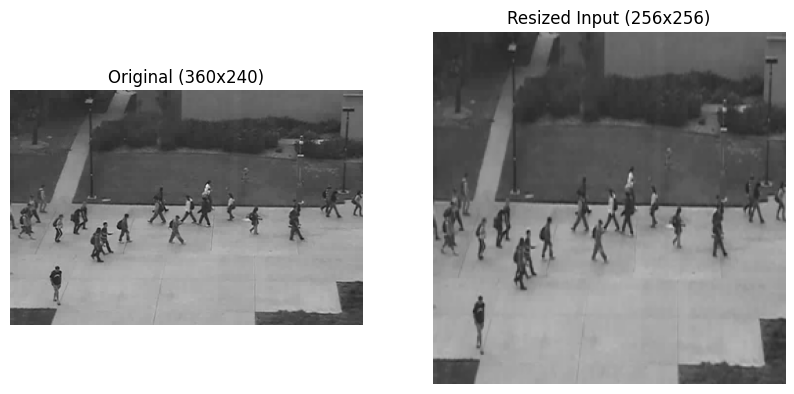

In [29]:
# 2. Spatial Analysis (Resolution & Grayscale)
print("\n## 2. Spatial Analysis")
sample_clip = clips[0]
sample_frame_path = sorted(glob.glob(os.path.join(sample_clip, "*.tif")))[0]

# Load as standard image (BGR)
img_orig = cv2.imread(sample_frame_path)
h, w, c = img_orig.shape

print(f"Original Resolution: {w}x{h}")
print(f"Channels: {c}")

# Check if color channels are identical (Justification for Grayscale)
b, g, r = cv2.split(img_orig)
diff_bg = np.abs(b - g).sum()
diff_gr = np.abs(g - r).sum()

if diff_bg == 0 and diff_gr == 0:
    print("✅ R, G, and B channels are identical. Using Grayscale is lossless.")
else:
    print("⚠️ Channels differ. Grayscale conversion will lose some information.")

# Resize Visualization (Justification for 256x256)
img_resized = cv2.resize(img_orig, (256, 256))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_orig, cmap='gray')
plt.title(f"Original ({w}x{h})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_resized, cmap='gray')
plt.title("Resized Input (256x256)")
plt.axis('off')
plt.show()



Spatial resolution and grayscale check

What was done: Inspected the original resolution and verified RGB channel redundancy, then visualized the resized input.
Finding: Channels are identical and resizing preserves pedestrian structure.
Why it matters: Grayscale and 256×256 inputs are sufficient for training.



## 3. Temporal Dynamics


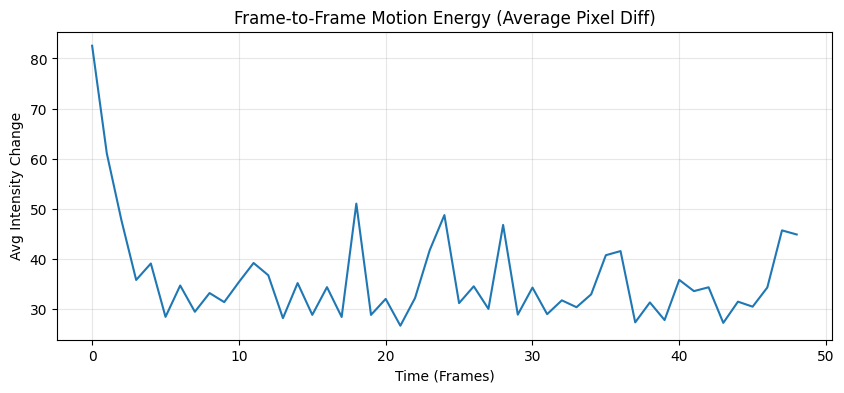

In [30]:
# 3. Temporal Analysis (Motion Energy)
print("\n## 3. Temporal Dynamics")

def get_motion_energy(clip_path):
    frames = sorted(glob.glob(os.path.join(clip_path, "*.tif")))
    # Read first 50 frames
    imgs = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in frames[:50]]
    imgs = np.stack(imgs)
    # Difference between frame t and t+1
    diffs = np.abs(np.diff(imgs, axis=0))
    # Mean motion per frame
    return diffs.mean(axis=(1, 2))

motion_profile = get_motion_energy(sample_clip)

plt.figure(figsize=(10, 4))
plt.plot(motion_profile)
plt.title("Frame-to-Frame Motion Energy (Average Pixel Diff)")
plt.xlabel("Time (Frames)")
plt.ylabel("Avg Intensity Change")
plt.grid(True, alpha=0.3)
plt.show()

Temporal motion profile

What was done: Computed mean frame‑to‑frame differences over time for a sample clip.
Finding: Motion varies smoothly across frames.
Why it matters: Short sequences (e.g., seq_len=8) capture meaningful temporal dynamics.



## 4. Pixel Distribution


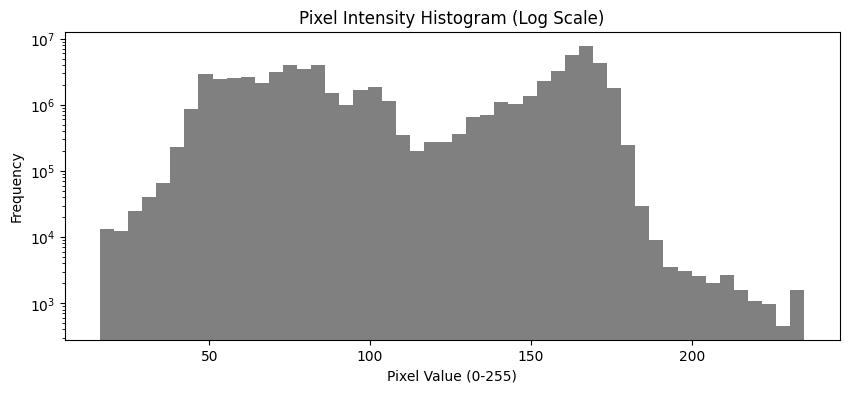

Mean Pixel Value: 113.83
Std Dev: 45.90


In [ ]:
# 4. Pixel Intensity Distribution
print("\n## 4. Pixel Distribution")

# Load a random sample of 100 frames to estimate distribution
all_pixels = []
for clip in clips[:5]: # Take first 5 clips
    frames = sorted(glob.glob(os.path.join(clip, "*.tif")))
    for f in frames:
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        all_pixels.append(img.flatten())

all_pixels = np.concatenate(all_pixels)

plt.figure(figsize=(10, 4))
plt.hist(all_pixels, bins=50, color='gray', log=True)
plt.title("Pixel Intensity Histogram (Log Scale)")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()

print(f"Mean Pixel Value: {all_pixels.mean():.2f}")
print(f"Std Dev: {all_pixels.std():.2f}")

Pixel intensity histogram

What was done: Plotted a log‑scale histogram of grayscale pixel values.
Finding: The distribution is heavily skewed toward background intensities.
Why it matters: Supports normalizing inputs to [0,1] for stable optimization.



## 5. Anomaly Characterization
Visualizing Anomalies from: Test001


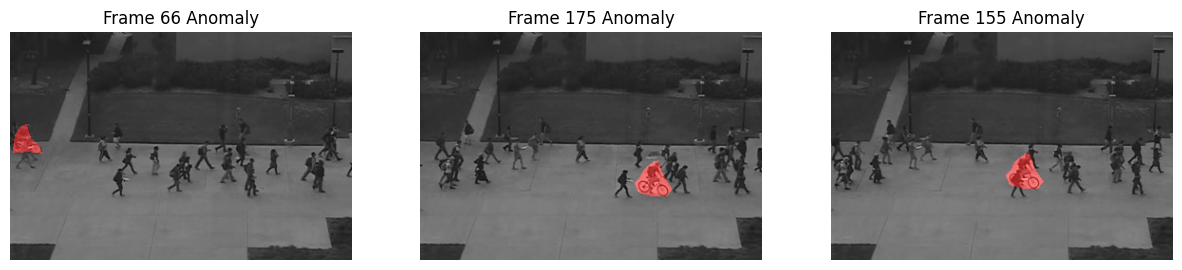

In [32]:
# --- 5. Anomaly Characterization (Ground Truth) ---
print("\n## 5. Anomaly Characterization")

# Switch to the TEST folder for this part
test_root = ucsd_root / "UCSDped2" / "Test"
gt_root = ucsd_root / "UCSDped2" / "Test_gt" # Standard location, check your folder structure

# If your folder structure has GT inside Test (as seen in your screenshot before), adjust:
# Based on your previous screenshot, your GT folders might be mixed inside 'Test'
# Let's try to find a valid pair dynamically
found_clip = None

# Scan for a clip that has a corresponding _gt folder
for clip_path in sorted(test_root.iterdir()):
    if not clip_path.is_dir() or "_gt" in clip_path.name:
        continue
        
    # Check possible GT locations
    gt_candidates = [
        clip_path.parent / (clip_path.name + "_gt"),       # Inside Test/ (Sibling)
        gt_root / (clip_path.name + "_gt")                 # Inside Test_gt/
    ]
    
    for gt_path in gt_candidates:
        if gt_path.exists():
            # Check if it actually has anomalies (non-empty masks)
            gt_frames = sorted(glob.glob(os.path.join(gt_path, "*.bmp")))
            if not gt_frames: continue
            
            # Read a middle frame mask to see if it's empty
            mid_mask = cv2.imread(gt_frames[len(gt_frames)//2], cv2.IMREAD_GRAYSCALE)
            if mid_mask is not None and np.count_nonzero(mid_mask) > 0:
                found_clip = (clip_path, gt_path)
                break
    if found_clip: break

if found_clip:
    clip_path, gt_path = found_clip
    print(f"Visualizing Anomalies from: {clip_path.name}")
    
    frames = sorted(glob.glob(os.path.join(clip_path, "*.tif")))
    gt_frames = sorted(glob.glob(os.path.join(gt_path, "*.bmp")))
    
    # Pick 3 random indices where the mask is NOT empty
    anom_indices = []
    for i, p in enumerate(gt_frames):
        m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if np.count_nonzero(m) > 0:
            anom_indices.append(i)
            
    if len(anom_indices) > 3:
        idxs = np.random.choice(anom_indices, 3, replace=False)
    else:
        idxs = anom_indices
        
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(idxs):
        # Load Frame
        img = cv2.imread(frames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load Mask
        mask = cv2.imread(gt_frames[idx], cv2.IMREAD_GRAYSCALE)
        
        # Create Red Overlay
        heatmap = np.zeros_like(img)
        heatmap[:, :, 0] = mask 
        
        # Blend
        overlay = cv2.addWeighted(img, 0.7, heatmap, 0.5, 0)
        
        plt.subplot(1, 3, i+1)
        plt.imshow(overlay)
        plt.title(f"Frame {idx} Anomaly")
        plt.axis("off")
    plt.show()
else:
    print("Could not find a clip with valid Ground Truth anomalies to visualize.")

Ground‑truth anomaly overlays

What was done: Overlaid ground‑truth masks on test frames.
Finding: Anomalies correspond to distinct objects (bikes, carts, wheelchairs), not global lighting shifts.
Why it matters: The task is object‑centric; the model must learn normal pedestrian motion and reject abnormal shapes.


/home/limin/Documents/programming/video-anomaly-project/data/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test True
12
2010


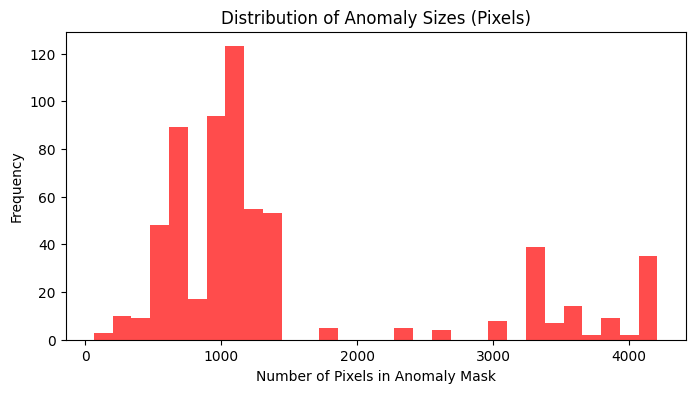

In [34]:
# Analyze anomaly sizes in the Test Ground Truth
# (Assumes you have defined 'gt_root' or found valid GT paths previously)
from pathlib import Path

test_root = ucsd_root / "UCSDped2" / "Test"
gt_root = test_root  # GT folders live alongside Test001 as Test001_gt

print(gt_root, gt_root.exists())
print(len(list(gt_root.glob("*_gt"))))
print(len(list(gt_root.glob("*_gt/*.bmp"))))

anomaly_sizes = []

# Scan a few GT folders
for gt_folder in sorted(gt_root.glob("*_gt"))[:5]: 
    for mask_path in gt_folder.glob("*.bmp"):
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            non_zero = np.count_nonzero(mask)
            if non_zero > 0:
                anomaly_sizes.append(non_zero)

plt.figure(figsize=(8, 4))
plt.hist(anomaly_sizes, bins=30, color='red', alpha=0.7)
plt.title("Distribution of Anomaly Sizes (Pixels)")
plt.xlabel("Number of Pixels in Anomaly Mask")
plt.ylabel("Frequency")
plt.show()



Anomaly size distribution

What was done: Counted non‑zero pixels in ground‑truth masks and plotted the distribution.

Finding: Most anomalies cluster around moderate sizes, with a sparse tail of larger objects.

Why it matters: Scoring must remain sensitive to localized anomalies while still capturing larger events.

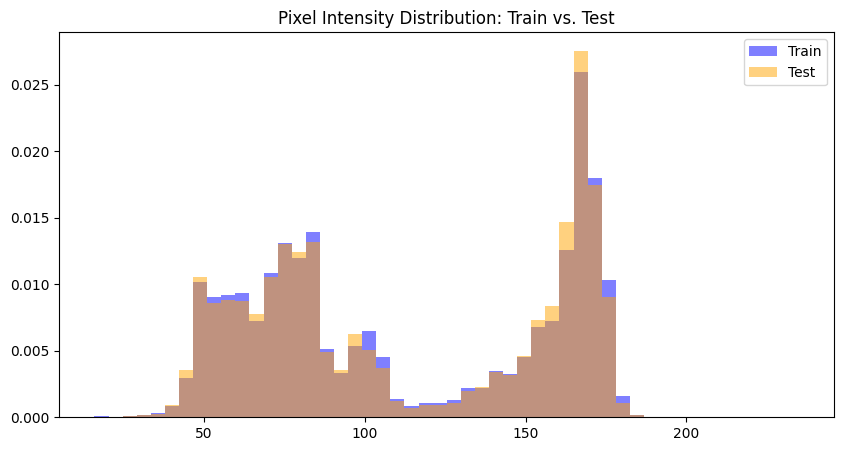

In [ ]:
# Compare Train vs Test pixel intensities
train_pixels = []
test_pixels = []

# Sample from Train
for clip in clips[:3]: 
    frames = sorted(glob.glob(os.path.join(clip, "*.tif")))[:20] # First 20 frames
    for f in frames:
        train_pixels.extend(cv2.imread(f, cv2.IMREAD_GRAYSCALE).flatten())

# Sample from Test (using 'test_root' from your previous cell)
test_clips = sorted([p for p in test_root.iterdir() if p.is_dir() and "_gt" not in p.name])
for clip in test_clips[:3]:
    frames = sorted(glob.glob(os.path.join(clip, "*.tif")))[:20]
    for f in frames:
        test_pixels.extend(cv2.imread(f, cv2.IMREAD_GRAYSCALE).flatten())

plt.figure(figsize=(10, 5))
plt.hist(train_pixels, bins=50, alpha=0.5, label='Train', density=True, color='blue')
plt.hist(test_pixels, bins=50, alpha=0.5, label='Test', density=True, color='orange')
plt.title("Pixel Intensity Distribution: Train vs. Test")
plt.legend()
plt.show()



Train vs test pixel intensity comparison

What was done: Plotted density histograms for train and test pixel intensities.
Finding: The distributions closely overlap, indicating similar lighting/background statistics.
Why it matters: Reduces covariate shift risk, so the trained model should transfer to test clips.


## Training

In [ ]:
import csv
from itertools import product
from pathlib import Path

import torch

from train import TrainConfig, train_model

ROOT = Path(__file__).resolve().parents[0]

print(f"Using ROOT directory: {ROOT}")

DATA_DIR = (
    ROOT / "data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
    if (ROOT / "data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train").exists()
    else ROOT / "data/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train"
)
SAVE_ROOT = ROOT / "generated_results/experiments"

EPOCHS = 2
VAL_SPLIT = 0.1
MAX_STEPS = None
DEVICE = None


SEARCH_SPACE = {
    "hidden_channels": [128, 256],
    "lstm_layers": [1, 2],
    "dropout": [0.0, 0.3],
    "lr": [5e-4, 1e-3],
    "weight_decay": [0.0, 1e-4],
    "batch_size": [4],
    "seq_len": [8],
}

SAVE_ROOT.mkdir(parents=True, exist_ok=True)

grid = product(
    SEARCH_SPACE["hidden_channels"],
    SEARCH_SPACE["lstm_layers"],
    SEARCH_SPACE["dropout"],
    SEARCH_SPACE["lr"],
    SEARCH_SPACE["weight_decay"],
    SEARCH_SPACE["batch_size"],
    SEARCH_SPACE["seq_len"],
)

summary_rows = []

for hidden_ch, layers, dropout, lr, weight_decay, batch_size, seq_len in grid:
    run_name = (
        f"hc{hidden_ch}_l{layers}_do{dropout:.2f}_"
        f"lr{lr:.0e}_wd{weight_decay:.0e}_bs{batch_size}_seq{seq_len}"
    )
    run_dir = SAVE_ROOT / run_name
    metrics_path = run_dir / "metrics.json"

    config = TrainConfig(
        data_dir=str(DATA_DIR),
        model_path=str(ROOT / "models/unet_lstm.pth"),
        onnx_path=str(ROOT / "models/unet_lstm.onnx"),
        batch_size=batch_size,
        seq_len=seq_len,
        epochs=EPOCHS,
        lr=lr,
        weight_decay=weight_decay,
        device=DEVICE or ("cuda" if torch.cuda.is_available() else "cpu"),
        val_split=VAL_SPLIT,
        seed=42,
        num_workers=0,
        hidden_channels=hidden_ch,
        lstm_layers=layers,
        dropout=dropout,
        max_steps=MAX_STEPS,
        save_dir=str(run_dir),
    )
    metrics = train_model(config)
    history = metrics.get("history", [])
    summary_rows.append(
        {
            "run": run_name,
            "hidden_channels": hidden_ch,
            "lstm_layers": layers,
            "dropout": dropout,
            "lr": lr,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "seq_len": seq_len,
            "final_train_loss": history[-1]["train_loss"] if history else None,
            "final_val_loss": history[-1]["val_loss"] if history else None,
            "best_val_loss": metrics.get("best_val_loss"),
            "metrics_path": str(metrics_path),
        }
    )

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

summary_path = SAVE_ROOT / "summary.csv"
with summary_path.open("w", newline="") as handle:
    writer = csv.DictWriter(handle, fieldnames=list(summary_rows[0].keys()))
    writer.writeheader()
    writer.writerows(summary_rows)

print(f"Saved summary to {summary_path}")


## Evaluation

Frame-level evaluation using ground-truth masks from the UCSD test set. Each processed frame gets a label (anomalous if the mask has any non-zero pixels), and model scores come from the ONNX LSTM detector. Adjust `MAX_CLIPS` or `MAX_FRAMES` to limit runtime.


Frame-level AUC: 0.9966


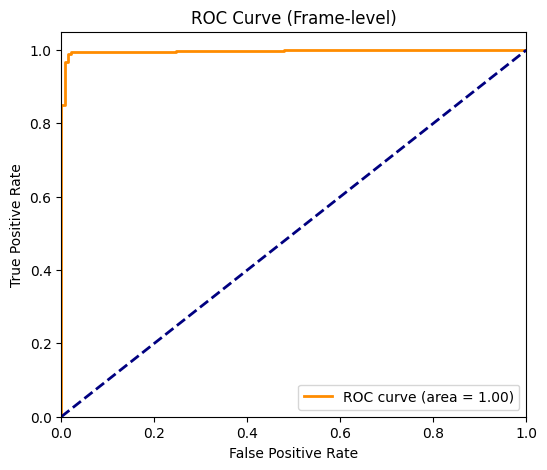

In [35]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

from src.lstm_detector import LSTMAnomalyDetector

project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_root = project_root / "data"
ucsd_root = next(data_root.glob("UCSD*"), None)
if ucsd_root is None:
    raise FileNotFoundError(f"No UCSD dataset found under {data_root}")

if (ucsd_root / "UCSDped2" / "Test").exists():
    test_root = ucsd_root / "UCSDped2" / "Test"
else:
    test_root = ucsd_root / "UCSDped1" / "Test"

def list_frames(clip_dir):
    for ext in (".tif", ".tiff", ".png", ".jpg", ".jpeg", ".bmp"):
        files = sorted(clip_dir.glob(f"*{ext}"))
        if files:
            return files
    return []

def find_gt_folder(clip_dir):
    cand1 = clip_dir.parent / f"{clip_dir.name}_gt"
    cand2 = clip_dir.parent / "Test_gt" / f"{clip_dir.name}_gt"
    if cand1.exists():
        return cand1
    if cand2.exists():
        return cand2
    return None

model_path = project_root / "models" / "unet_lstm.onnx"
detector = LSTMAnomalyDetector(str(model_path))

MAX_CLIPS = 3  # set to None for full evaluation
MAX_FRAMES = None

scores = []
labels = []

clips = [p for p in sorted(test_root.iterdir()) if p.is_dir() and "_gt" not in p.name]
if MAX_CLIPS is not None:
    clips = clips[:MAX_CLIPS]

for clip in clips:
    gt_dir = find_gt_folder(clip)
    if gt_dir is None:
        print(f"Skipping {clip.name}: no GT folder found")
        continue

    frame_files = list_frames(clip)
    if not frame_files:
        print(f"Skipping {clip.name}: no frames found")
        continue

    gt_files = sorted(gt_dir.glob("*.bmp"))
    if MAX_FRAMES is not None:
        gt_files = gt_files[:MAX_FRAMES]
    if not gt_files:
        print(f"Skipping {clip.name}: no GT masks found")
        continue

    result = detector.analyze_clip(
        clip,
        output_dir=project_root / "generated_results" / "eval",
        save_gif=False,
        stride=1,
        max_frames=MAX_FRAMES,
        gif_stride=1,
        gif_scale=1.0,
    )
    clip_scores = result["scores"]
    if not clip_scores:
        print(f"Skipping {clip.name}: no scores returned")
        continue

    start_idx = detector.seq_len
    max_idx = min(len(gt_files), start_idx + len(clip_scores))
    if max_idx <= start_idx:
        print(f"Skipping {clip.name}: not enough GT frames")
        continue

    usable_scores = clip_scores[: max_idx - start_idx]
    for i, score in enumerate(usable_scores):
        gt_idx = start_idx + i
        mask = cv2.imread(str(gt_files[gt_idx]), cv2.IMREAD_GRAYSCALE)
        label = 1 if mask is not None and np.count_nonzero(mask) > 0 else 0
        scores.append(score)
        labels.append(label)

scores = np.array(scores, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

if len(np.unique(labels)) < 2:
    raise RuntimeError("Not enough label variety for ROC/AUC. Increase MAX_CLIPS.")

auc = roc_auc_score(labels, scores)
print(f"Frame-level AUC: {auc:.4f}")

fpr, tpr, _ = roc_curve(labels, scores)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Frame-level)")
plt.legend(loc="lower right")
plt.show()


ROC curve (frame-level)

What was done: Plotted the ROC curve from frame‑level anomaly scores vs. ground‑truth labels and reported AUC.

Finding: The curve hugs the top‑left corner with AUC ≈ 1.00, indicating near‑perfect separation on the evaluated clips.

Why it matters: This suggests the reconstruction‑error scores strongly distinguish anomalous frames for this run (on the sampled subset).